### Calulate ssh spectra at every grid point (Spatial structure of peaks)

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import signal
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from netCDF4 import Dataset
from xmitgcm import open_mdsdataset
import time

In [2]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

ds = open_mdsdataset(outdir, prefix=['eta'])
ds2 = open_mdsdataset(outdir2, prefix=['eta'])

In [3]:
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

nx = len(lon)
ny = len(lat)

# centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)

# depth with bay
depth = ds['Depth'][:]

In [4]:
filename = 'ssh_spectra_3peaks_febTS_cm.nc'
sshData = xr.open_dataset(filename)

In [5]:
sshData

<xarray.Dataset>
Dimensions:  (lat: 612, lon: 512)
Coordinates:
  * lon      (lon) float64 -122.0 -122.0 -122.0 -121.9 ... -114.1 -114.0 -114.0
  * lat      (lat) float64 27.01 27.02 27.03 27.05 ... 35.28 35.29 35.3 35.32
Data variables:
    p1_psd   (lat, lon) float64 ...
    p2_psd   (lat, lon) float64 ...
    p3_psd   (lat, lon) float64 ...
    p1_freq  (lat, lon) float64 ...
    p2_freq  (lat, lon) float64 ...
    p3_freq  (lat, lon) float64 ...
Attributes:
    title:        SSH max PSD and frequency of main peaks SVB-no SVB for FebT...
    author:       Karina Ramos Musalem
    institution:  ICACC-UNAM
    source:       /notebooks/MITgcm/domain5/ssh_spectra_domain.ipynb
    description:  This file conains the PSD and frequency of the 3 peaks in S...
    timeStamp:    Sat Dec  4 05:47:15 2021

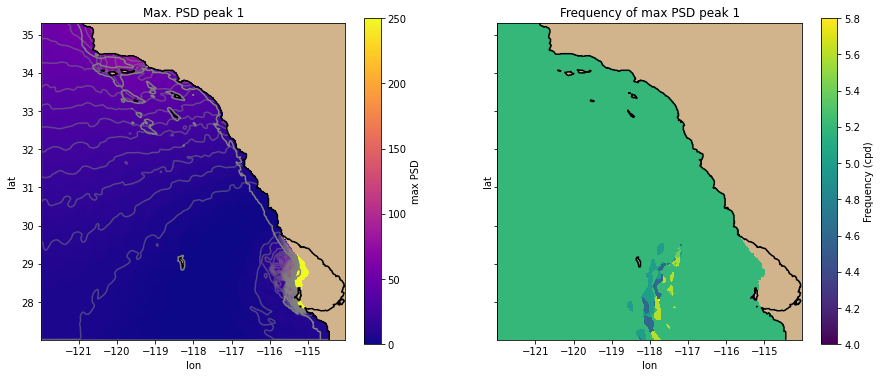

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6), sharey=True)
ax1.set_facecolor('tan')
pc1 = ax1.pcolormesh(lon,lat, sshData.p1_psd, cmap='plasma', vmin=0, vmax=250)
plt.colorbar(pc1, ax=ax1, label='max PSD')
levels=np.arange(0,250,5)
cn1 = ax1.contour(lon,lat, sshData.p1_psd, levels, colors='0.5', alpha=0.5)

ax1.contour(lon,lat,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])

ax1.set_xlabel('lon')
ax1.set_ylabel('lat')
ax1.set_title('Max. PSD peak 1')
ax1.set_aspect(1)

ax2.set_facecolor('tan')
pc2 = ax2.pcolormesh(lon, lat, sshData.p1_freq, cmap='viridis')
plt.colorbar(pc2, ax=ax2, label='Frequency (cpd)')
ax2.contour(lon,lat,depth,levels=[0], colors=['k'])
ax2.set_xlabel('lon')
ax2.set_ylabel('lat')
ax2.set_title('Frequency of max PSD peak 1')
ax2.set_aspect(1)


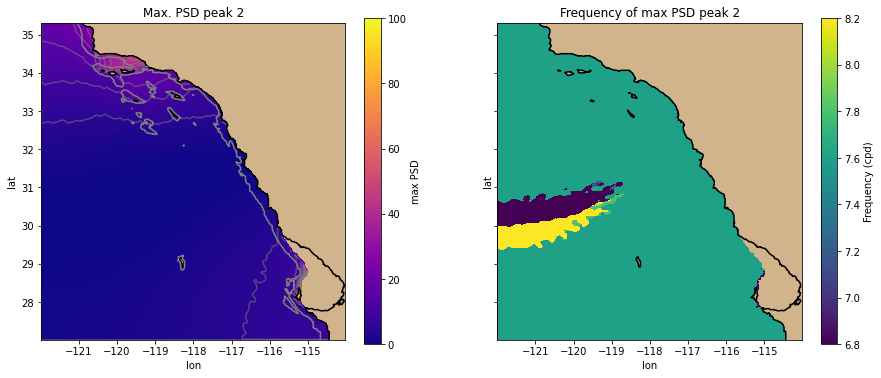

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6), sharey=True)
ax1.set_facecolor('tan')
pc1 = ax1.pcolormesh(lon,lat, sshData.p2_psd, cmap='plasma', vmin=0, vmax=100)
plt.colorbar(pc1, ax=ax1, label='max PSD')
levels=np.arange(0,100,5)
cn1 = ax1.contour(lon,lat, sshData.p2_psd, levels, colors='0.5', alpha=0.5)

ax1.contour(lon,lat,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax1.set_xlabel('lon')
ax1.set_ylabel('lat')
ax1.set_title('Max. PSD peak 2')
ax1.set_aspect(1)

ax2.set_facecolor('tan')
pc2 = ax2.pcolormesh(lon, lat, sshData.p2_freq, cmap='viridis')
plt.colorbar(pc2, ax=ax2, label='Frequency (cpd)')
ax2.contour(lon,lat,depth,levels=[0], colors=['k'])
ax2.set_xlabel('lon')
ax2.set_ylabel('lat')
ax2.set_title('Frequency of max PSD peak 2')
ax2.set_aspect(1)


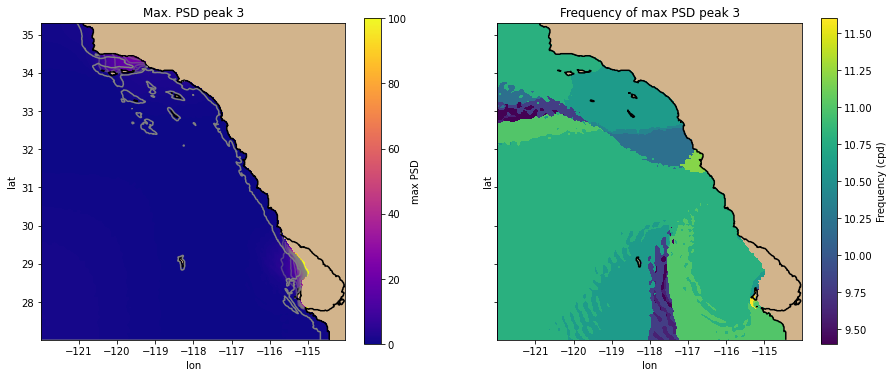

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6), sharey=True)
ax1.set_facecolor('tan')
pc1 = ax1.pcolormesh(lon,lat, sshData.p3_psd, cmap='plasma', vmin=0, vmax=100)
plt.colorbar(pc1, ax=ax1, label='max PSD')
ax1.contour(lon,lat,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
levels=np.arange(0,100,5)
cn1 = ax1.contour(lon,lat, sshData.p3_psd, levels, colors='0.5', alpha=0.5)

ax1.set_xlabel('lon')
ax1.set_ylabel('lat')
ax1.set_title('Max. PSD peak 3')
ax1.set_aspect(1)

ax2.set_facecolor('tan')
pc2 = ax2.pcolormesh(lon, lat, sshData.p3_freq, cmap='viridis')
plt.colorbar(pc2, ax=ax2, label='Frequency (cpd)')
ax2.contour(lon,lat,depth,levels=[0], colors=['k'])
ax2.set_xlabel('lon')
ax2.set_ylabel('lat')
ax2.set_title('Frequency of max PSD peak 3')
ax2.set_aspect(1)


In [11]:
print('%1.3e' %sshData.p1_psd[529,176])

6.434e+01


In [12]:
print('%1.3e' %sshData.p2_psd[529,176])

3.112e+01


In [13]:
print('%1.3e' %sshData.p3_psd[529,176])

1.083e+01


In [14]:
print('%1.1e' %np.max(sshData.p3_psd))

1.5e+02


In [15]:
612-50

562

64.33629136921593
5.2
31.121617364427465
7.6
10.828498013735194
10.8
64.33629136921593
5.2
31.121617364427465
7.6
10.828498013735194
10.8
64.69454912734629
5.2
31.636887588536243
7.6
11.376214208171954
10.8
66.69391913661492
5.2
33.90834710815497
7.6
13.24377166946817
10.8
68.92650841229887
5.2
36.46823926000458
7.6
15.465728411592707
10.8


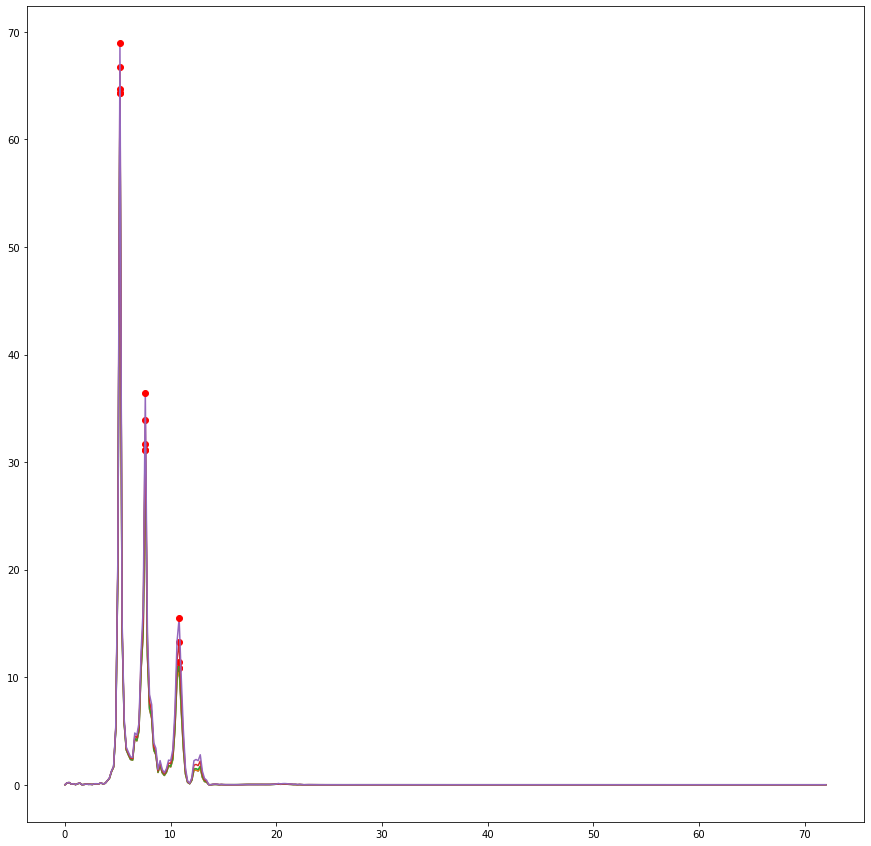

In [16]:
fig, (ax1) = plt.subplots(1,1,figsize=(15,15), sharey=True)


samp_freq = 1/600 # 10 min data
  
lons = [176,176,175]
lats = [529,530,531]

for ii in lons: #nx
    if ii%10 == 0:
        print(ii)
    for jj in lats: #ny
        if mask[0,jj,ii]== True:
            continue
        else:
            freq, psd = signal.periodogram((ds.ETAN[:,jj,ii]-ds2.ETAN[:,jj,ii])*100, samp_freq, detrend='constant')
        
        print(np.max(psd[20:30])) # find max PSD for peak 1 (these limits shouldn't be hard coded!)
        print(freq[np.argmax(psd[20:30])+20]*86400) # find corresponding frequency
        
        print(np.max(psd[34:45])) # find max PSD for peak 2
        print(freq[np.argmax(psd[34:45])+34]*86400)
        
        print(np.max(psd[47:59])) # find max PSD for peak 3
        print(freq[np.argmax(psd[47:59])+47]*86400)

        ax1.plot(freq*86400,psd)
        ax1.plot(freq[np.argmax(psd[20:30])+20]*86400,np.max(psd[20:30]),'ro')
        ax1.plot(freq[np.argmax(psd[34:45])+34]*86400,np.max(psd[34:45]),'ro')
        ax1.plot(freq[np.argmax(psd[47:59])+47]*86400,np.max(psd[47:59]),'ro')

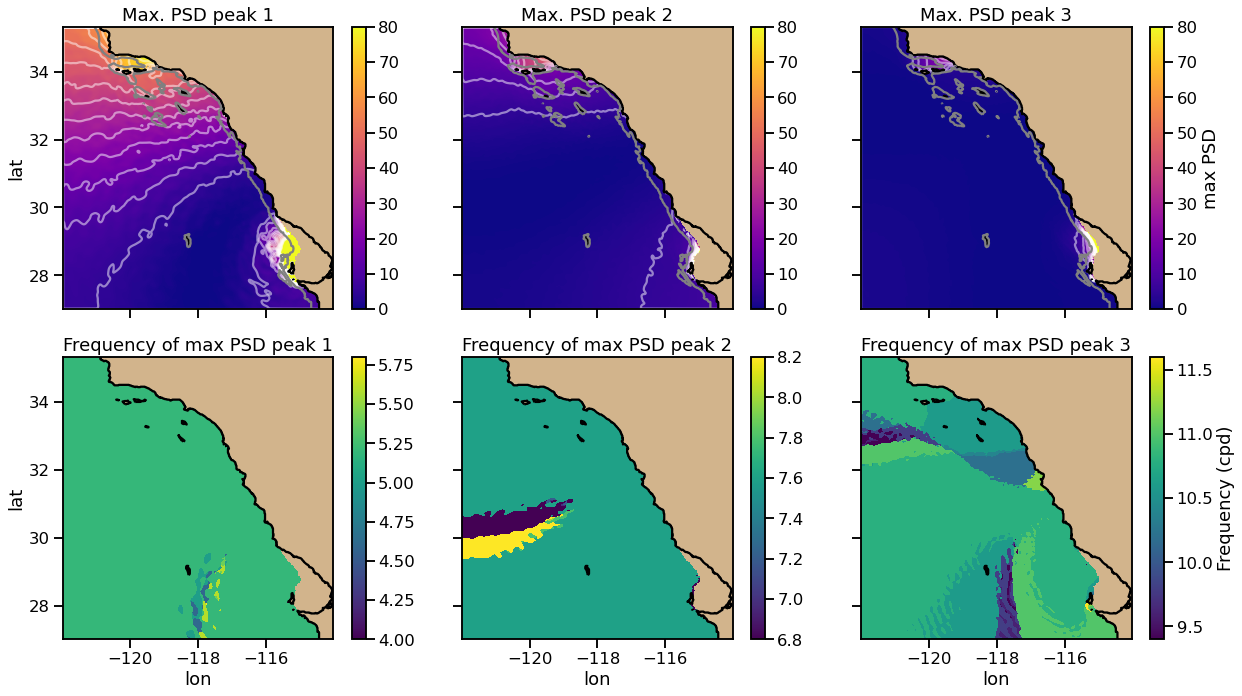

In [37]:
fig, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(18,10), sharey=True, sharex=True)
sns.set_context('talk')
ax1.set_facecolor('tan')
pc1 = ax1.pcolormesh(lon,lat, sshData.p1_psd, cmap='plasma', vmin=0, vmax=80)
plt.colorbar(pc1, ax=ax1)
levels=np.arange(0,80,5)
cn1 = ax1.contour(lon,lat, sshData.p1_psd, levels, colors='1', alpha=0.5)
ax1.contour(lon,lat,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax1.set_ylabel('lat')
ax1.set_title('Max. PSD peak 1')
ax1.set_aspect(1)

ax2.set_facecolor('tan')
pc2 = ax2.pcolormesh(lon,lat, sshData.p2_psd, cmap='plasma', vmin=0, vmax=80)
plt.colorbar(pc2, ax=ax2)
levels=np.arange(0,80,5)
cn2 = ax2.contour(lon,lat, sshData.p2_psd, levels, colors='1', alpha=0.5)
ax2.contour(lon,lat,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax2.set_title('Max. PSD peak 2')
ax2.set_aspect(1)

ax3.set_facecolor('tan')
pc3 = ax3.pcolormesh(lon,lat, sshData.p3_psd, cmap='plasma', vmin=0, vmax=80)
plt.colorbar(pc3, ax=ax3, label='max PSD')
levels=np.arange(0,80,5)
cn3 = ax3.contour(lon,lat, sshData.p3_psd, levels, colors='1', alpha=0.5)
ax3.contour(lon,lat,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax3.set_title('Max. PSD peak 3')
ax3.set_aspect(1)

ax4.set_facecolor('tan')
pc4 = ax4.pcolormesh(lon, lat, sshData.p1_freq, cmap='viridis')
plt.colorbar(pc4, ax=ax4)
ax4.contour(lon,lat,depth,levels=[0], colors=['k'])
ax4.set_xlabel('lon')
ax4.set_ylabel('lat')
ax4.set_title('Frequency of max PSD peak 1')
ax4.set_aspect(1)

ax5.set_facecolor('tan')
pc5 = ax5.pcolormesh(lon, lat, sshData.p2_freq, cmap='viridis')
plt.colorbar(pc5, ax=ax5)
ax5.contour(lon,lat,depth,levels=[0], colors=['k'])
ax5.set_xlabel('lon')
ax5.set_title('Frequency of max PSD peak 2')
ax5.set_aspect(1)

ax6.set_facecolor('tan')
pc6 = ax6.pcolormesh(lon, lat, sshData.p3_freq, cmap='viridis')
plt.colorbar(pc6, ax=ax6, label='Frequency (cpd)')
ax6.contour(lon,lat,depth,levels=[0], colors=['k'])
ax6.set_xlabel('lon')
ax6.set_title('Frequency of max PSD peak 3')
ax6.set_aspect(1)
plt.tight_layout()

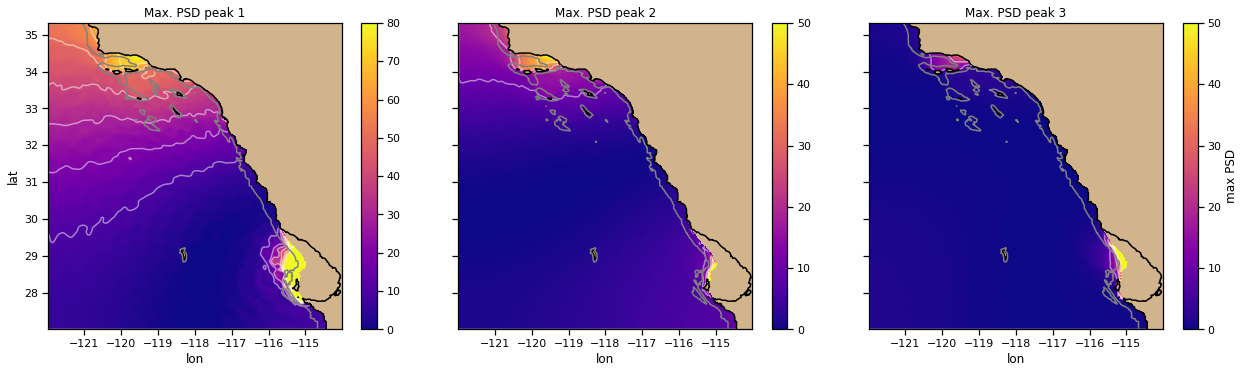

In [39]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(18,5), sharey=True, sharex=True)
sns.set_context('notebook')
ax1.set_facecolor('tan')
pc1 = ax1.pcolormesh(lon,lat, sshData.p1_psd, cmap='plasma', vmin=0, vmax=80)
plt.colorbar(pc1, ax=ax1)
levels=np.arange(0,80,10)
cn1 = ax1.contour(lon,lat, sshData.p1_psd, levels, colors='1', alpha=0.5)
ax1.contour(lon,lat,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax1.set_ylabel('lat')
ax1.set_xlabel('lon')
ax1.set_title('Max. PSD peak 1')
ax1.set_aspect(1)

ax2.set_facecolor('tan')
pc2 = ax2.pcolormesh(lon,lat, sshData.p2_psd, cmap='plasma', vmin=0, vmax=50)
plt.colorbar(pc2, ax=ax2)
levels=np.arange(0,50,10)
cn2 = ax2.contour(lon,lat, sshData.p2_psd, levels, colors='1', alpha=0.5)
ax2.contour(lon,lat,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax2.set_title('Max. PSD peak 2')
ax2.set_aspect(1)
ax2.set_xlabel('lon')

ax3.set_facecolor('tan')
pc3 = ax3.pcolormesh(lon,lat, sshData.p3_psd, cmap='plasma', vmin=0, vmax=50)
plt.colorbar(pc3, ax=ax3, label='max PSD')
levels=np.arange(0,50,10)
cn3 = ax3.contour(lon,lat, sshData.p3_psd, levels, colors='1', alpha=0.5)
ax3.contour(lon,lat,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax3.set_title('Max. PSD peak 3')
ax3.set_aspect(1)
ax3.set_xlabel('lon')
plt.tight_layout()